# Truncated Records 2025

The content limit for page captures will eventually be raised from 1 to 5 MiB in one of the crawls in 2025.

This notebook is to estimate the impact on the WARC size and other parameters before a change to the content limit.

If a change to the content limit is made, also the real changes are evaluated here.

Counts of truncated records are aggregated per MIME type from the [columnar index](https://commoncrawl.org/blog/index-to-warc-files-and-urls-in-columnar-format) using [AWS Athena](https://aws.amazon.com/athena/) and the following SQL query (cf. [average-warc-record-length-by-mime-type.sql](https://github.com/commoncrawl/cc-index-table/blob/main/src/sql/examples/cc-index/average-warc-record-length-by-mime-type.sql)):

```sql
SELECT COUNT(*) as n_pages,
       COUNT(*) * 100.0 / SUM(COUNT(*)) OVER() as perc_pages,
       AVG(warc_record_length) as avg_warc_record_length,
       SUM(warc_record_length) as sum_warc_record_length,
       MAX(warc_record_length) as max_warc_record_length,
       approx_percentile(warc_record_length, ARRAY[.01,.02,.05,.1,.15,.25,.5,.75,.85,.9,.95,.98,.99,.995])
          as percentiles_warc_record_length,
       SUM(warc_record_length) * 100.0 / SUM(SUM(warc_record_length)) OVER() as perc_warc_storage,
       SUM(case when content_truncated is null then 0 else 1 end) * 100.0 / COUNT(*) as perc_truncated,
       SUM(case when content_truncated is not null then warc_record_length else 0 end)
          as sum_warc_record_length_truncated,
       SUM(case when content_truncated is not null then warc_record_length else 0 end)
          * 100.0 / SUM(SUM(warc_record_length)) OVER() as perc_warc_storage_truncated,
       SUM(case when content_truncated = 'length' then warc_record_length else 0 end)
          as sum_warc_record_length_truncated_length,
       SUM(case when content_truncated = 'length' then warc_record_length else 0 end)
          * 100.0 / SUM(SUM(warc_record_length)) OVER() as perc_warc_storage_truncated_length,
       content_mime_detected,
       histogram(content_truncated) as reason_truncated,
       slice(
         array_sort(
           map_entries(map_filter(
             histogram(regexp_extract(url_path, '\.[a-zA-Z0-9_-]{1,7}$')),
             (k, v) -> v > 4)),
           (a, b) -> IF(a[2] < b[2], 1, IF(a[2] = b[2], 0, -1))),
         1, 25) as common_url_path_suffixes,
       COUNT(DISTINCT url_host_tld) as uniq_tlds,
       approx_distinct(url_host_registered_domain) as uniq_domains,
       approx_distinct(url_host_name) as uniq_hosts,
       slice(
         array_sort(
           map_entries(map_filter(histogram(url_host_tld), (k, v) -> v > 4)),
           (a, b) -> IF(a[2] < b[2], 1, IF(a[2] = b[2], 0, -1))),
         1, 25) as top_tlds,
       approx_most_frequent(25, url_host_registered_domain, 1000) as top_domains
FROM "ccindex"."ccindex"
WHERE crawl = 'CC-MAIN-2025-05'
  AND subset = 'warc'
GROUP BY content_mime_detected
HAVING (COUNT(*) >= 10) -- ignore MIME types seen less than 10 times
ORDER BY n_pages DESC;
```

In [1]:
import json
import pandas as pd

df = pd.read_csv('data/warc-record-size-truncation-by-mime-type-CC-MAIN-2025-05.csv')

df[['content_mime_detected', 'n_pages', 'perc_warc_storage',
    'perc_truncated', 'perc_warc_storage_truncated', 'reason_truncated']].head(20)

,content_mime_detected,n_pages,perc_warc_storage,perc_truncated,perc_warc_storage_truncated,reason_truncated
0,text/html,2731118776,85.520576,2.398080,10.172436,"{length=64028128, disconnect=1466160, time=129}"
1,application/xhtml+xml,263868889,5.153182,0.631314,0.217108,"{length=1515360, disconnect=150472, time=10}"
2,application/pdf,19926901,9.045050,26.312124,4.968546,"{length=5232274, disconnect=10799, time=118}"
3,text/plain,3184175,0.036948,2.959793,0.020463,"{length=90376, disconnect=3853, time=16}"
4,application/atom+xml,3167720,0.012043,0.123590,0.000916,"{length=3899, disconnect=16}"
5,application/rss+xml,2445452,0.017838,0.504856,0.002287,"{length=11915, disconnect=429, time=2}"
6,application/xml,1943043,0.018160,1.408667,0.003037,"{length=26964, disconnect=404, time=3}"
7,text/calendar,1040301,0.002292,0.127944,0.000236,"{length=1208, disconnect=123}"
8,application/json,958061,0.004572,0.905162,0.001052,"{length=8596, disconnect=76}"
9,application/octet-stream,428542,0.033369,10.163765,0.026076,"{length=43363, disconnect=178, time=15}"


The aggregations show which MIME types are mostly affected by truncations.

Now let's look into the reasons of the truncation and load the histograms with reason counts into columns:

In [2]:
# expand embedded Presto/Trino/Athena histogram as columns into data frame
def unroll_histograms(df):
    # - transform to valid JSON
    df['reasons_truncation'] = df['reason_truncated'].str.replace('(\\w+)=', '"\\1":', regex=True)
    df['top_domains'] = df['top_domains'].str.replace('([a-z0-9.-]+)=', '"\\1":', regex=True)

    # - load columns in data frame
    truncation_reason = df['reasons_truncation'].apply(
        lambda x: json.loads(x) if type(x) == str else {}
    ).apply(pd.Series).apply(lambda s: s.fillna(0).astype(int)).add_prefix('trunc_reason_')

    # - join with original data
    df = df.join(truncation_reason)

    df['n_pages_truncated'] \
        = df['trunc_reason_length'] + df['trunc_reason_time'] + df['trunc_reason_disconnect']
    df['trunc_reason_length_perc'] = 100.0 * df['trunc_reason_length'] / df['n_pages']
    df['trunc_length_gib'] = df['sum_warc_record_length_truncated_length'] / 2**30

    return df

df = unroll_histograms(df)
df[['content_mime_detected', 'n_pages', 'perc_truncated', 'n_pages_truncated',
      'trunc_reason_length', 'trunc_reason_length_perc', 'trunc_length_gib']
    ].sort_values(by=['trunc_reason_length'], ascending=False).head(20)

,content_mime_detected,n_pages,perc_truncated,n_pages_truncated,trunc_reason_length,trunc_reason_length_perc,trunc_length_gib
0,text/html,2731118776,2.398080,65494417,64028128,2.344392,9414.133382
2,application/pdf,19926901,26.312124,5243191,5232274,26.257339,4615.277669
1,application/xhtml+xml,263868889,0.631314,1665842,1515360,0.574285,199.879604
3,text/plain,3184175,2.959793,94245,90376,2.838286,18.930999
9,application/octet-stream,428542,10.163765,43556,43363,10.118728,24.214183
6,application/xml,1943043,1.408667,27371,26964,1.387720,2.810701
5,application/rss+xml,2445452,0.504856,12346,11915,0.487231,2.118575
28,application/epub+zip,43534,27.105251,11800,11794,27.091469,11.324456
8,application/json,958061,0.905162,8672,8596,0.897229,0.974798
50,application/x-matlab-data,12258,59.781367,7328,7322,59.732420,6.644439


### Estimate of storage increase

If the content limit is increased from 1 MiB to 5 MiB, what would be the estimate for storage occupied by the records which are now not truncated anymore or hit the new limit?

- upper bound estimate of the storage **increase**, as product of
  - 4 (assumed that all captures move from 1 to 5 MiB = 4 MiB more content) 
  - WARC storage occupied by truncated records (because of the content length limit)
- lower bound estimate
  - 1 (assuming that on average the content size doubles)
  - 95th percentile of WARC record length
  - number of truncated records (because of the content length limit)
- more realistic "mid" estimate
  - 1.5 (increase from 1 to 2.5 MiB on average)
  - WARC storage occupied by truncated records (because of the content length limit)

In [3]:
# see SQL query above for the percentiles
percentiles = [.01,.02,.05,.1,.15,.25,.5,.75,.85,.9,.95,.98,.99,.995]

df['perc95_warc_record_length'] \
    = df['percentiles_warc_record_length'].apply(lambda p : json.loads(p)[10]
                                                   if type(p) == str else 0)

In [4]:
df['WARC GiB'] = df['sum_warc_record_length'] / 2**30
df['WARC GiB trunc'] = df['sum_warc_record_length_truncated_length'] / 2**30
df['+ GiB upper'] = 5 * df['sum_warc_record_length_truncated_length'] / 2**30
df['+ GiB lower'] = 1 * df['trunc_reason_length'] * 1 * df['perc95_warc_record_length'] / 2**30
df['+ GiB mid'] = 1.5 * df['sum_warc_record_length_truncated_length'] / 2**30
df['avg WARC MiB'] = df['avg_warc_record_length'] / 2**20
df['perc95 WARC MiB'] = df['perc95_warc_record_length'] / 2**20
df['max WARC MiB'] = df['max_warc_record_length'] / 2**20
df['avg WARC MiB trunc'] = df['sum_warc_record_length_truncated_length'] / df['trunc_reason_length'] / 2**20

df_1mib = df # store for later comparison

df[['content_mime_detected', 'WARC GiB', 'WARC GiB trunc',
      '+ GiB upper', '+ GiB lower', '+ GiB mid', 'trunc_reason_length',
      'avg WARC MiB', 'perc95 WARC MiB', 'max WARC MiB', 'avg WARC MiB trunc']
    ].sort_values(by=['trunc_reason_length'], ascending=False).head(20)

,content_mime_detected,WARC GiB,WARC GiB trunc,+ GiB upper,+ GiB lower,+ GiB mid,trunc_reason_length,avg WARC MiB,perc95 WARC MiB,max WARC MiB,avg WARC MiB trunc
0,text/html,79481.638957,9414.133382,47070.666908,5940.603275,14121.200072,64028128,0.029801,0.095008,1.001537,0.150560
2,application/pdf,8406.344064,4615.277669,23076.388346,5046.918160,6922.916504,5232274,0.431984,0.987724,1.004257,0.903249
1,application/xhtml+xml,4789.296311,199.879604,999.398020,88.692456,299.819406,1515360,0.018586,0.059934,0.998480,0.135068
3,text/plain,34.339026,18.930999,94.654997,3.977500,28.396499,90376,0.011043,0.045067,1.001639,0.214497
9,application/octet-stream,31.012809,24.214183,121.070914,26.242660,36.321274,43363,0.074105,0.619710,1.002588,0.571808
6,application/xml,16.877369,2.810701,14.053504,1.117693,4.216051,26964,0.008895,0.042446,1.001264,0.106741
5,application/rss+xml,16.578616,2.118575,10.592875,0.296815,3.177863,11915,0.006942,0.025509,0.758889,0.182075
28,application/epub+zip,19.962399,11.324456,56.622282,11.529023,16.986685,11794,0.469552,1.000994,1.003022,0.983232
8,application/json,4.249273,0.974798,4.873990,0.107124,1.462197,8596,0.004542,0.012761,1.001091,0.116123
50,application/x-matlab-data,6.804147,6.644439,33.222194,7.137591,9.966658,7322,0.568400,0.998210,1.001732,0.929241


In [5]:
print("Upper bound TiB: {:.2f} (+{:.2f}%)".format(
    df['+ GiB upper'].sum() / 2**10,
    100.0 * df['+ GiB upper'].sum() / df['WARC GiB'].sum()))
print("Lower bound TiB: {:.2f} (+{:.2f}%)".format(
    df['+ GiB lower'].sum() / 2**10,
    100.0 * df['+ GiB lower'].sum() / df['WARC GiB'].sum()))
print("Mid estimate TiB: {:.2f} (+{:.2f}%)".format(
    df['+ GiB mid'].sum() / 2**10,
    100.0 * df['+ GiB mid'].sum() / df['WARC GiB'].sum()))

Upper bound TiB: 70.13 (+77.27%)
Lower bound TiB: 10.93 (+12.05%)
Mid estimate TiB: 21.04 (+23.18%)


### Distribution of WARC Record Length By MIME Type



In [6]:
perc_df = df['percentiles_warc_record_length'].apply(
    lambda p : json.loads(p) if type(p) == str else 0).apply(
    lambda p : pd.Series(data=p, index=percentiles))
perc_df = df[['content_mime_detected']].join(perc_df)
perc_df.head(20)

,content_mime_detected,0.01,0.02,0.05,0.1,0.15,0.25,0.5,0.75,0.85,0.9,0.95,0.98,0.99,0.995
0,text/html,1093,1806,4070,6170,8114,11397,20095,36634,52607,66742,99623,152039,183379,200379
1,application/xhtml+xml,1730,2317,3343,4357,5190,6764,11305,21112,31543,42710,62845,96233,127993,157305
2,application/pdf,7929,15240,32982,59027,83633,130792,332588,825888,970124,1011298,1035704,1046053,1048516,1049330
3,text/plain,613,644,693,778,843,954,1348,2471,4860,10002,47256,169523,256093,323308
4,application/atom+xml,1133,1187,1284,1307,1326,1366,1520,2569,3799,5431,8416,22481,49185,79305
5,application/rss+xml,869,924,1012,1102,1183,1370,2120,4879,9027,14061,26748,58419,91270,137055
6,application/xml,640,644,747,933,1081,1362,2187,6329,13977,23718,44508,61062,93276,139326
7,text/calendar,780,838,902,970,1018,1099,1307,1645,1865,2145,2867,6176,14967,33288
8,application/json,661,687,762,858,917,1012,1393,2611,4824,6738,13381,40050,80014,114701
9,application/octet-stream,503,511,558,593,631,695,1134,9897,50253,242023,649813,1031031,1049584,1049809


In [7]:
top_mime_types = {'text/html', 'application/xhtml+xml', 'application/pdf'}


perc_df[perc_df['content_mime_detected'].isin({'text/html', 'application/xhtml+xml', 'application/pdf'})]

,content_mime_detected,0.01,0.02,0.05,0.1,0.15,0.25,0.5,0.75,0.85,0.9,0.95,0.98,0.99,0.995
0,text/html,1093,1806,4070,6170,8114,11397,20095,36634,52607,66742,99623,152039,183379,200379
1,application/xhtml+xml,1730,2317,3343,4357,5190,6764,11305,21112,31543,42710,62845,96233,127993,157305
2,application/pdf,7929,15240,32982,59027,83633,130792,332588,825888,970124,1011298,1035704,1046053,1048516,1049330


<AxesSubplot: xlabel='percentile'>

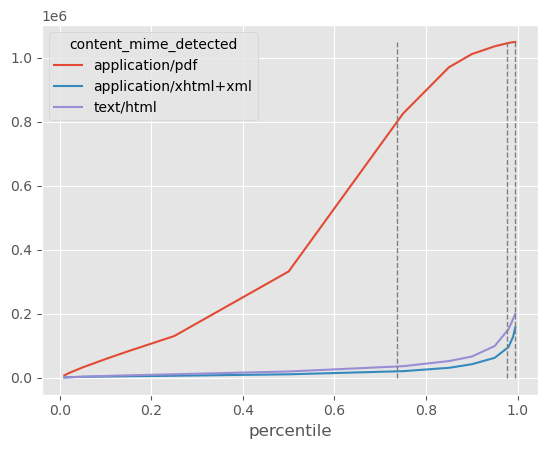

In [8]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

perc_df_top = perc_df[perc_df['content_mime_detected'] \
                .isin(top_mime_types)] \
                .melt(id_vars=['content_mime_detected'], var_name='percentile', value_name='record_length')
ax = perc_df_top \
        .pivot(index='percentile', columns='content_mime_detected', values='record_length') \
        .plot()

max_record_length = perc_df_top['record_length'].max()
trunc_percentage_top = [
    (100-df.loc[df['content_mime_detected'] == 'application/pdf', 'perc_truncated'])/100,
    (100-df.loc[df['content_mime_detected'] == 'application/xhtml+xml', 'perc_truncated'])/100,
    (100-df.loc[df['content_mime_detected'] == 'text/html', 'perc_truncated'])/100,
]
ax.vlines(x=trunc_percentage_top,
          ymin=0, ymax=max_record_length, colors='grey', ls='--', lw=1, label='')

ax

Notes about in the plot above:
- the distribution of the record lengths is distorted if there are many truncated records. For example, 25% of the PDF records are truncated, consequently the record length is "growing" slower above the .75 percentile.
- the vertical lines indicate the percentage of truncated records for the given MIME types 


## TLDs and Domains with Truncated Content

These statistics try to uncover any oddities in the distributions of truncated and overlong pages/documents over top-level and pay-level domains.

```sql
SELECT COUNT(*) as n_pages,
       content_mime_detected,
       slice(
         array_sort(
           map_entries(map_filter(histogram(url_host_tld), (k, v) -> v > 4)),
           (a, b) -> IF(a[2] < b[2], 1, IF(a[2] = b[2], 0, -1))),
         1, 25) as top_tlds,
       approx_most_frequent(50, url_host_registered_domain, 2000) as top_domains
FROM "ccindex"."ccindex"
WHERE crawl = 'CC-MAIN-2025-05'
  AND subset = 'warc'
  AND content_truncated = 'length'
GROUP BY content_mime_detected
HAVING (COUNT(*) >= 10) -- ignore MIME types seen less than 10 times
ORDER BY n_pages DESC;
```

In [9]:
from collections import Counter

def compare_top_domains(df_all, df_trunc, mime='text/html', n=25):
    da = pd.DataFrame(
                Counter(df_all.loc[df_all['content_mime_detected'] == mime,
                                          'top_domains'].apply(json.loads).values[0]).most_common(),
                columns = ['domain', 'count_all']
    )
    dt = pd.DataFrame(
                Counter(df_trunc.loc[df_trunc['content_mime_detected'] == mime,
                                              'top_domains'].apply(json.loads).values[0]).most_common(),
                columns = ['domain', 'count_trunc']
    )
    d = dt.merge(da, how = 'outer').fillna(0).astype({'count_all': int, 'count_trunc': int})
    d['%'] = 100.0 * d['count_trunc'] / d['count_all']
    print(mime)
    return d.head(n)


df_trunc = pd.read_csv('data/warc-truncation-domains-CC-MAIN-2025-05.csv')
df_trunc['top_domains'] = df_trunc['top_domains'].str.replace('([a-z0-9.-]+)=', '"\\1":', regex=True)


compare_top_domains(df, df_trunc, mime='text/html')

text/html


,domain,count_trunc,count_all,%
0,cian.ru,396174,0,inf
1,google.com,261575,907870,28.811944
2,investing.com,209620,0,inf
3,ebay.com,154563,0,inf
4,kayak.com,153965,0,inf
5,atlassian.net,144704,0,inf
6,statcounter.com,136324,0,inf
7,blogspot.com,121515,11997861,1.012806
8,shein.com,110114,0,inf
9,yahoo.com,104344,1054361,9.896421


**Note**: for the MIME type "text/html" there are certain domains which might require a closer look because the rate of truncated docs is high.

In [10]:
compare_top_domains(df, df_trunc, mime='application/xhtml+xml')

application/xhtml+xml


,domain,count_trunc,count_all,%
0,blogspot.com,77275,6451535,1.197777
1,developpez.com,19889,0,inf
2,poshmark.com,18378,0,inf
3,halfords.com,15767,0,inf
4,socrata.com,14804,0,inf
5,boardgamearena.com,14691,0,inf
6,onxmaps.com,11722,0,inf
7,vuodatus.net,7896,0,inf
8,house.gov,6088,0,inf
9,drogariasaopaulo.com.br,6009,0,inf


In [11]:
compare_top_domains(df, df_trunc, mime='application/pdf')

application/pdf


,domain,count_trunc,count_all,%
0,jimcontent.com,23099,85679,26.959932
1,finalsite.net,14536,70510,20.615516
2,windows.net,11931,40256,29.637818
3,wsimg.com,10669,36193,29.478076
4,forddirect.com,10522,0,inf
5,amazonaws.com,10090,25285,39.905082
6,arxiv.org,8976,18923,47.434339
7,ca.gov,8816,44895,19.636931
8,hal.science,8483,16117,52.633865
9,nrc.gov,7318,34855,20.995553


In [12]:
def compare_top_tlds(df_all, df_trunc, mime='text/html', n=25):
    da = dict()
    [da.update(i) for i in df_all.loc[df_all['content_mime_detected'] == mime,
                                             'top_tlds'].apply(json.loads).values[0]]
    da = pd.DataFrame(da.items(), columns = ['tld', 'count_all'])
    dt = dict()
    [dt.update(i) for i in df_trunc.loc[df_trunc['content_mime_detected'] == mime,
                                                 'top_tlds'].apply(json.loads).values[0]]
    dt = pd.DataFrame(dt.items(), columns = ['tld', 'count_trunc'])
    d = dt.merge(da, how = 'outer').fillna(0).astype({'count_all': int, 'count_trunc': int})
    d['%'] = 100.0 * d['count_trunc'] / d['count_all']
    print(mime)
    return d.head(n)

df['top_tlds'] = df['top_tlds'].str.replace('([a-z0-9-]+),', '"\\1":', regex=True)
df_trunc['top_tlds'] = df_trunc['top_tlds'].str.replace('([a-z0-9-]+),', '"\\1":', regex=True)

compare_top_tlds(df, df_trunc, mime='text/html')

text/html


,tld,count_trunc,count_all,%
0,com,35911127,1196436910,3.001506
1,org,3010643,142642887,2.110616
2,uk,2290946,62522803,3.664177
3,de,1834358,113394412,1.617679
4,ru,1589712,112089907,1.418247
5,net,1457425,86429230,1.686264
6,br,1246223,42671465,2.920507
7,au,1142920,33085884,3.454404
8,fr,1072570,48807448,2.197554
9,ca,763557,24840353,3.073857


In [13]:
compare_top_tlds(df, df_trunc, mime='application/xhtml+xml')

application/xhtml+xml


,tld,count_trunc,count_all,%
0,com,624020,107402662,0.581010
1,ru,261408,18293254,1.428986
2,net,49223,12250071,0.401818
3,br,47314,3785948,1.249727
4,org,37626,14874244,0.252961
5,de,34354,10400244,0.330319
6,ca,33259,2197131,1.513747
7,ar,23176,0,inf
8,fr,19165,4632746,0.413686
9,nl,19109,2375891,0.804288


In [14]:
compare_top_tlds(df, df_trunc, mime='application/pdf')

application/pdf


,tld,count_trunc,count_all,%
0,com,1062445,3978544,26.704367
1,org,524607,1899369,27.620068
2,de,284086,1114713,25.485125
3,jp,280361,1163876,24.088563
4,ru,192376,590728,32.565919
5,it,153948,723174,21.287823
6,gov,143574,774991,18.525893
7,net,142688,533763,26.732464
8,uk,140201,561029,24.989974
9,fr,128446,469522,27.356759


### A Closer Look on Domains With Large Amounts of Truncated Content

The aim is to identify domains which will "profiteers" if the content limit threshold is increased - domains which already (with the current 1 MiB limit) have many truncated captures or occupy a large amount of WARC storage.

Get reliable metrics on the level of registered "pay-level" domains
- number of truncated pages
- compared to / ratio of all page captures
- GiB truncated content in WARC files

```sql
with tmp1 as (select
  count(*) as count,
  content_mime_detected,
  url_host_registered_domain
from "ccindex"
where crawl = 'CC-MAIN-2025-05'
  and subset = 'warc'
group by content_mime_detected,
  url_host_registered_domain),
tmp2 as (select
  count(*) as count,
  sum(warc_record_length) as sum_warc_record_length,
  content_mime_detected,
  url_host_registered_domain
from "ccindex"
where crawl = 'CC-MAIN-2025-05'
  and subset = 'warc'
  and content_truncated = 'length'
group by content_mime_detected,
  url_host_registered_domain
having count(*) >= 10000
    or sum(warc_record_length) > 10*1024*1024*cast(1024 as bigint))
select trunc.count as count_trunc,
  all.count as count_total,
  format('%.3f', 100.0 * trunc.count / all.count) as perc_trunc,
  format('%,.2f', trunc.sum_warc_record_length / (1024.0*1024*1024)) storage_trunc_gib,
  all.content_mime_detected as content_mime_detected,
  all.url_host_registered_domain as url_host_registered_domain
from tmp1 as all
 right outer join tmp2 as trunc
 on all.content_mime_detected = trunc.content_mime_detected
and all.url_host_registered_domain = trunc.url_host_registered_domain
order by trunc.sum_warc_record_length desc;
```

In [15]:
domains = pd.read_csv('data/warc-truncation-domains-detailed-CC-MAIN-2025-05.csv')
domains.head(50)

,count_trunc,count_total,perc_trunc,storage_trunc_gib,content_mime_detected,url_host_registered_domain
0,382732,641341,59.677,53.44,text/html,cian.ru
1,251855,994310,25.330,42.19,text/html,google.com
2,208234,272893,76.306,29.89,text/html,investing.com
3,131529,211563,62.170,23.87,text/html,atlassian.net
4,33131,35897,92.295,22.52,text/html,forbes.ru
5,154334,271968,56.747,20.86,text/html,ebay.com
6,23073,85633,26.944,20.75,application/pdf,jimcontent.com
7,148671,153963,96.563,19.20,text/html,kayak.com
8,93800,716987,13.083,17.42,text/html,yahoo.com
9,101144,251546,40.209,16.90,text/html,shein.com


## Changes after the content limit from 1 MiB to 5 MiB

Starting with the March 2025 crawl (CC-MAIN-2025-13), the content limit was increased from 1 MiB to 5 MiB.

Below, the changes between Jan/Feb and March crawls are evaluated, mostly be repeating the steps above.

In [16]:
# January 2025 (CC-MAIN-2025-05)
df_1mib[['content_mime_detected', 'n_pages', 'perc_warc_storage',
         'perc_truncated', 'perc_warc_storage_truncated', 'reason_truncated']].head(5)

,content_mime_detected,n_pages,perc_warc_storage,perc_truncated,perc_warc_storage_truncated,reason_truncated
0,text/html,2731118776,85.520576,2.398080,10.172436,"{length=64028128, disconnect=1466160, time=129}"
1,application/xhtml+xml,263868889,5.153182,0.631314,0.217108,"{length=1515360, disconnect=150472, time=10}"
2,application/pdf,19926901,9.045050,26.312124,4.968546,"{length=5232274, disconnect=10799, time=118}"
3,text/plain,3184175,0.036948,2.959793,0.020463,"{length=90376, disconnect=3853, time=16}"
4,application/atom+xml,3167720,0.012043,0.123590,0.000916,"{length=3899, disconnect=16}"


In [17]:
# February 2025 (CC-MAIN-2025-08)
df = pd.read_csv('data/warc-record-size-truncation-by-mime-type-CC-MAIN-2025-08.csv')
df = unroll_histograms(df)
df_1mib_feb = df

df[['content_mime_detected', 'n_pages', 'perc_warc_storage',
    'perc_truncated', 'perc_warc_storage_truncated', 'reason_truncated']].head(5)

,content_mime_detected,n_pages,perc_warc_storage,perc_truncated,perc_warc_storage_truncated,reason_truncated
0,text/html,2397212413,83.685091,2.212378,9.242725,"{length=51714890, disconnect=1320378, time=128}"
1,application/xhtml+xml,244867406,5.288293,0.612091,0.228452,"{length=1362318, disconnect=136418, time=76}"
2,application/pdf,21005751,10.655827,25.715205,5.812974,"{length=5386780, disconnect=14630, time=262}"
3,text/plain,3431228,0.041980,2.430063,0.021522,"{length=81945, disconnect=1416, time=20}"
4,application/atom+xml,3079149,0.012186,0.090609,0.000758,"{length=2772, disconnect=18}"


In [18]:
df = pd.read_csv('data/warc-record-size-truncation-by-mime-type-CC-MAIN-2025-13.csv')

df[['content_mime_detected', 'n_pages', 'perc_warc_storage',
    'perc_truncated', 'perc_warc_storage_truncated', 'reason_truncated']].head(5)

,content_mime_detected,n_pages,perc_warc_storage,perc_truncated,perc_warc_storage_truncated,reason_truncated
0,text/html,2464098263,78.188052,0.090185,0.655481,"{length=940023, disconnect=1281807, time=422}"
1,application/xhtml+xml,241222218,4.610878,0.082012,0.049386,"{length=53680, disconnect=144069, time=82}"
2,application/pdf,18893854,16.546366,6.790764,5.871564,"{length=1267302, disconnect=14574, time=1161}"
3,text/plain,3567341,0.085377,0.853633,0.041604,"{length=29854, disconnect=583, time=15}"
4,application/atom+xml,3098706,0.011011,0.007777,0.000390,"{length=232, disconnect=9}"


In [19]:
df_1mib[['content_mime_detected', 'n_pages', 'perc_truncated', 'n_pages_truncated',
         'trunc_reason_length', 'trunc_reason_length_perc', 'trunc_length_gib']
       ].sort_values(by=['trunc_reason_length'], ascending=False).head(5)

,content_mime_detected,n_pages,perc_truncated,n_pages_truncated,trunc_reason_length,trunc_reason_length_perc,trunc_length_gib
0,text/html,2731118776,2.398080,65494417,64028128,2.344392,9414.133382
2,application/pdf,19926901,26.312124,5243191,5232274,26.257339,4615.277669
1,application/xhtml+xml,263868889,0.631314,1665842,1515360,0.574285,199.879604
3,text/plain,3184175,2.959793,94245,90376,2.838286,18.930999
9,application/octet-stream,428542,10.163765,43556,43363,10.118728,24.214183


In [20]:
df_1mib_feb[['content_mime_detected', 'n_pages', 'perc_truncated', 'n_pages_truncated',
             'trunc_reason_length', 'trunc_reason_length_perc', 'trunc_length_gib']
           ].sort_values(by=['trunc_reason_length'], ascending=False).head(5)

,content_mime_detected,n_pages,perc_truncated,n_pages_truncated,trunc_reason_length,trunc_reason_length_perc,trunc_length_gib
0,text/html,2397212413,2.212378,53035396,51714890,2.157293,7517.254954
2,application/pdf,21005751,25.715205,5401672,5386780,25.644310,4746.097534
1,application/xhtml+xml,244867406,0.612091,1498812,1362318,0.556349,185.117815
6,application/xml,1994154,8.599286,171483,170526,8.551295,15.302876
3,text/plain,3431228,2.430063,83381,81945,2.388212,17.543959


In [21]:
df = unroll_histograms(df)
df_5mib = df

df[['content_mime_detected', 'n_pages', 'perc_truncated', 'n_pages_truncated',
      'trunc_reason_length', 'trunc_reason_length_perc', 'trunc_length_gib']
    ].sort_values(by=['trunc_reason_length'], ascending=False).head(5)

,content_mime_detected,n_pages,perc_truncated,n_pages_truncated,trunc_reason_length,trunc_reason_length_perc,trunc_length_gib
2,application/pdf,18893854,6.790764,1283037,1267302,6.707483,5651.001914
0,text/html,2464098263,0.090185,2222252,940023,0.038149,598.257201
1,application/xhtml+xml,241222218,0.082012,197831,53680,0.022253,45.832576
3,text/plain,3567341,0.853633,30452,29854,0.836870,39.998305
9,application/octet-stream,518253,2.777987,14397,14229,2.745570,45.574482


In [22]:
def coarse_metrics(df, name):
    print(name)
    print('{:8.3f} TiB  Total WARC records (response records only)'.format(
        df['sum_warc_record_length'].sum()/2**40))
    print('{:8.3f} kiB  Average WARC record size'.format(
        df['sum_warc_record_length'].sum()/df['n_pages'].sum()/1024))
    print('{:8.3f} kiB  Average WARC record size truncated'.format(
        df['sum_warc_record_length_truncated'].sum()/df['n_pages_truncated'].sum()/1024))
    print('{:8.3f} %  Truncated pages'.format(
        100.0*df['n_pages_truncated'].sum()/df['n_pages'].sum()))

coarse_metrics(df_1mib, 'CC-MAIN-2025-05')
coarse_metrics(df_1mib_feb, 'CC-MAIN-2025-08')
coarse_metrics(df_5mib, 'CC-MAIN-2025-13')

CC-MAIN-2025-05
  90.760 TiB  Total WARC records (response records only)
  32.149 kiB  Average WARC record size
 207.770 kiB  Average WARC record size truncated
   2.399 %  Truncated pages
CC-MAIN-2025-08
  79.783 TiB  Total WARC records (response records only)
  31.968 kiB  Average WARC record size
 219.750 kiB  Average WARC record size truncated
   2.254 %  Truncated pages
CC-MAIN-2025-13
  94.235 TiB  Total WARC records (response records only)
  36.917 kiB  Average WARC record size
1828.689 kiB  Average WARC record size truncated
   0.139 %  Truncated pages
